In [1]:
import os
os.chdir('..')
import warnings
warnings.filterwarnings('ignore')


In [2]:
import pandas as pd  # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import numpy as np # type: ignore
import wbdata
import datetime


In [3]:
from scripts.changePoint import loadData
price_data=loadData()


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Importing plotly failed. Interactive plots will not work.
2024-11-04 15:34:28.455885: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-04 15:34:28.461278: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-04 15:34:28.480438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730723668.513395   27928 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730723668.523786   27928 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been reg

### Read loaded dataset

In [4]:
price_data.head(10)


,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63
5,27-May-87,18.60
6,28-May-87,18.60
7,29-May-87,18.58
8,01-Jun-87,18.65
9,02-Jun-87,18.68


### Find the information of the dataset

In [5]:
price_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB


### Check missing value

In [6]:
price_data.isnull().sum()


Date     0
Price    0
dtype: int64

In [7]:
price_data['Date'] = pd.to_datetime(price_data['Date'])


In [8]:
price_data.head(10)


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
5,1987-05-27,18.60
6,1987-05-28,18.60
7,1987-05-29,18.58
8,1987-06-01,18.65
9,1987-06-02,18.68


### For Plot Prices Over Time Set Date into Index

In [9]:
price_data.set_index('Date',inplace=True)


In [10]:
price_data.head(10)


,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
1987-05-27,18.60
1987-05-28,18.60
1987-05-29,18.58
1987-06-01,18.65


### Oil Price Over Time

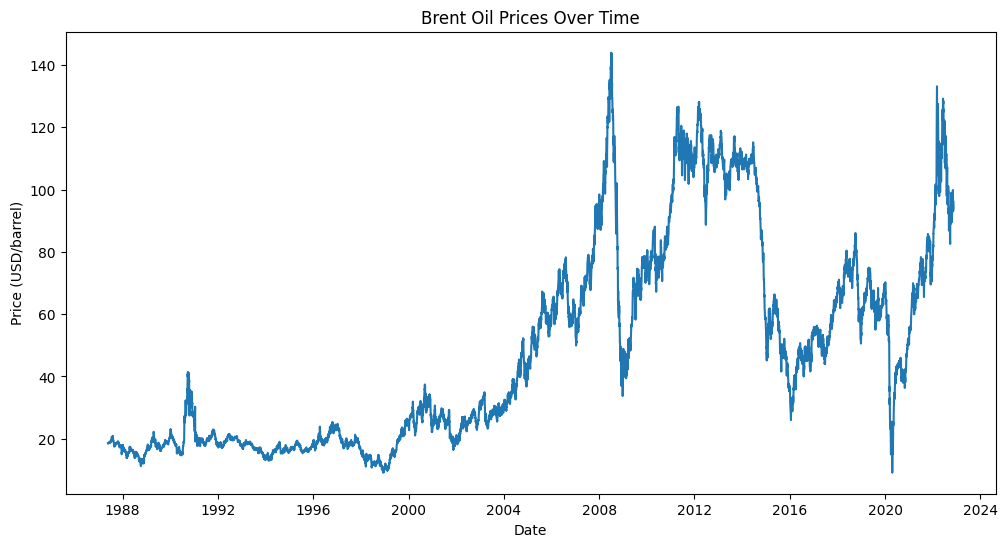

In [11]:
from scripts.changePoint import oilPricOverTime

oilPricOverTime(price_data)


### Decompose the time series

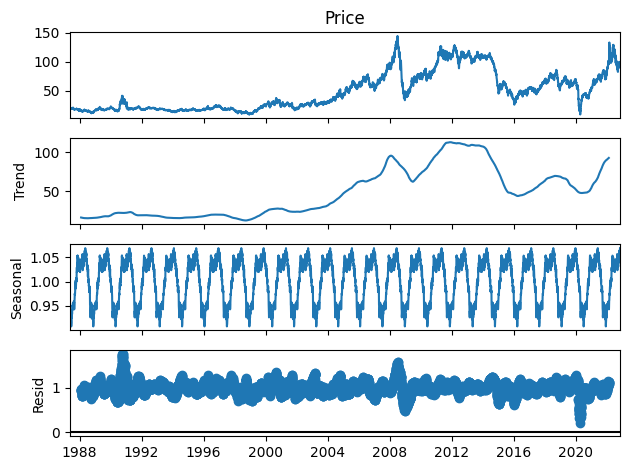

In [12]:
from scripts.changePoint import seasonalDecompose
seasonalDecompose(price_data)


In [13]:
price_data.reset_index()


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
9006,2022-11-08,96.85
9007,2022-11-09,93.05
9008,2022-11-10,94.25
9009,2022-11-11,96.37


### Load Sample Oil Price Events

In [14]:
from scripts.changePoint import loadEventData
event_affect_oil= loadEventData()


In [15]:
event_affect_oil.head()
event_affect_oil['Date'] = pd.to_datetime(event_affect_oil['Date'])


### Merge Event With Price

In [16]:
from scripts.changePoint import mergePriceWithEvent
merged_price_event = mergePriceWithEvent(price_data,event_affect_oil)


### To verify the effect of events on oli price

In [17]:
merged_price_event.head(11)


,Date,Price,Event,Impact_on_Oil_Prices
0,1987-10-19,19.10,Black Monday stock market crash,Decline due to economic concerns
1,1990-08-02,22.25,Iraq invades Kuwait (First Gulf War),Spike due to supply fears
2,2001-09-11,29.12,9/11 Terrorist Attacks,"Initial decline, then recovery"
3,2003-03-20,28.00,Iraq War begins,Increased due to instability
4,2008-07-11,143.68,Oil reaches all-time high of $147,Record high prices
5,2010-04-20,84.73,Deepwater Horizon Oil Spill,"Brief increase, then normalization"
6,2011-01-25,96.76,Arab Spring protests,Rise due to regional instability
7,2014-06-09,110.55,Oil price downturn begins,Downturn from oversupply
8,2016-01-20,26.01,Oil price drop below $30,Further decline due to low demand
9,2018-11-02,71.11,US sanctions on Iran,Rise due to geopolitical tension


### Merge all price data with events and 0

In [18]:
from scripts.changePoint import mergeAllPriceWithEvent
merged_price_event = mergeAllPriceWithEvent(price_data,event_affect_oil)


In [19]:
from scripts.changePoint import saveMergedData
saveMergedData(merged_price_event)


In [20]:
merged_price_event.tail(10)


,Date,Price,Event,Impact_on_Oil_Prices
9001,2022-11-01,95.12,0,0
9002,2022-11-02,96.07,0,0
9003,2022-11-03,95.29,0,0
9004,2022-11-04,99.53,0,0
9005,2022-11-07,99.87,0,0
9006,2022-11-08,96.85,0,0
9007,2022-11-09,93.05,0,0
9008,2022-11-10,94.25,0,0
9009,2022-11-11,96.37,0,0
9010,2022-11-14,93.59,0,0


### Oil Price Over Time with Significant Events

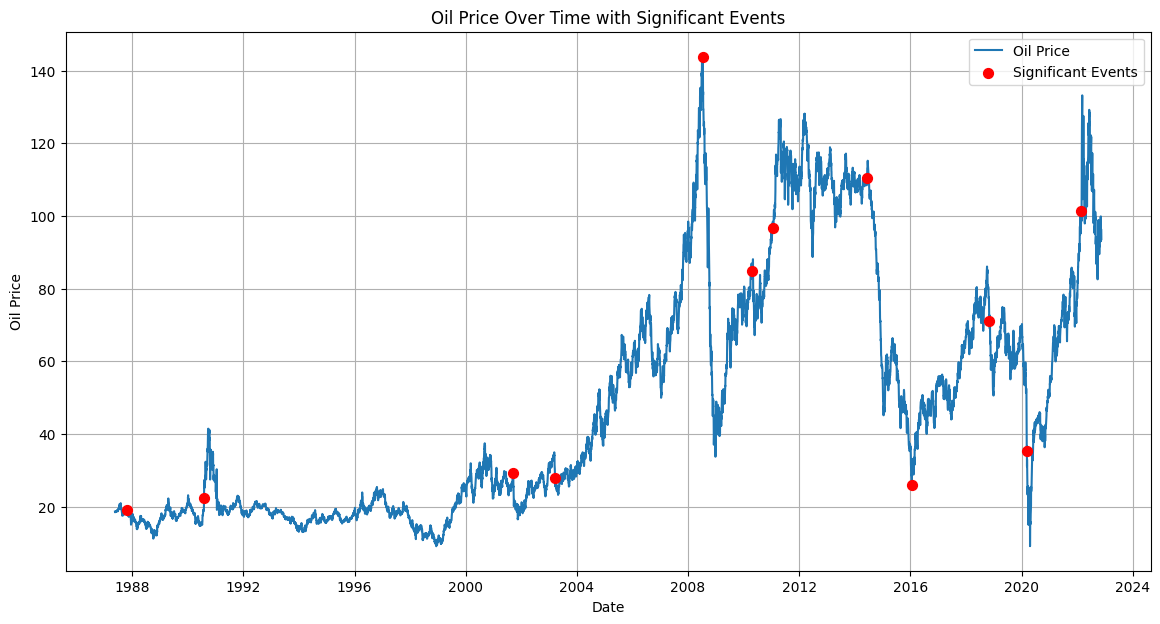

In [21]:
from scripts.changePoint import priceWithSignificantEvent
priceWithSignificantEvent(merged_price_event)


### Oil Price Over Time with Events Name

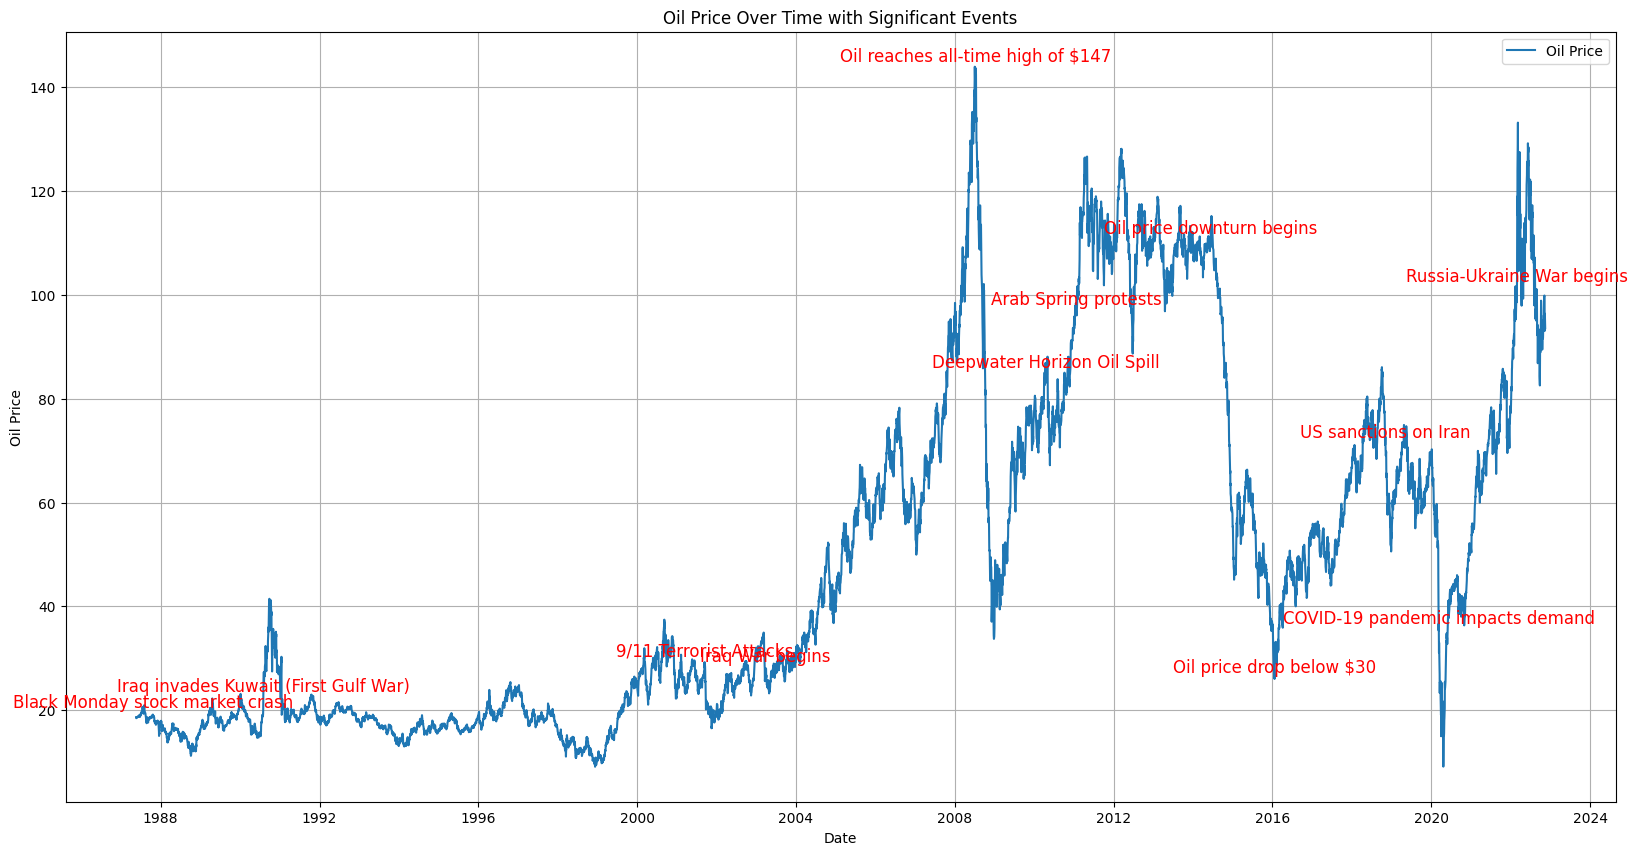

In [22]:
from scripts.changePoint import priceWithSignificantEventName
priceWithSignificantEventName(merged_price_event)


## Advanced Analysis and Modelling of Brent Oil Prices

###  Implementing Change Point Detection Using Bayesian Models

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [change_point]
>NUTS: [mean1, mean2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


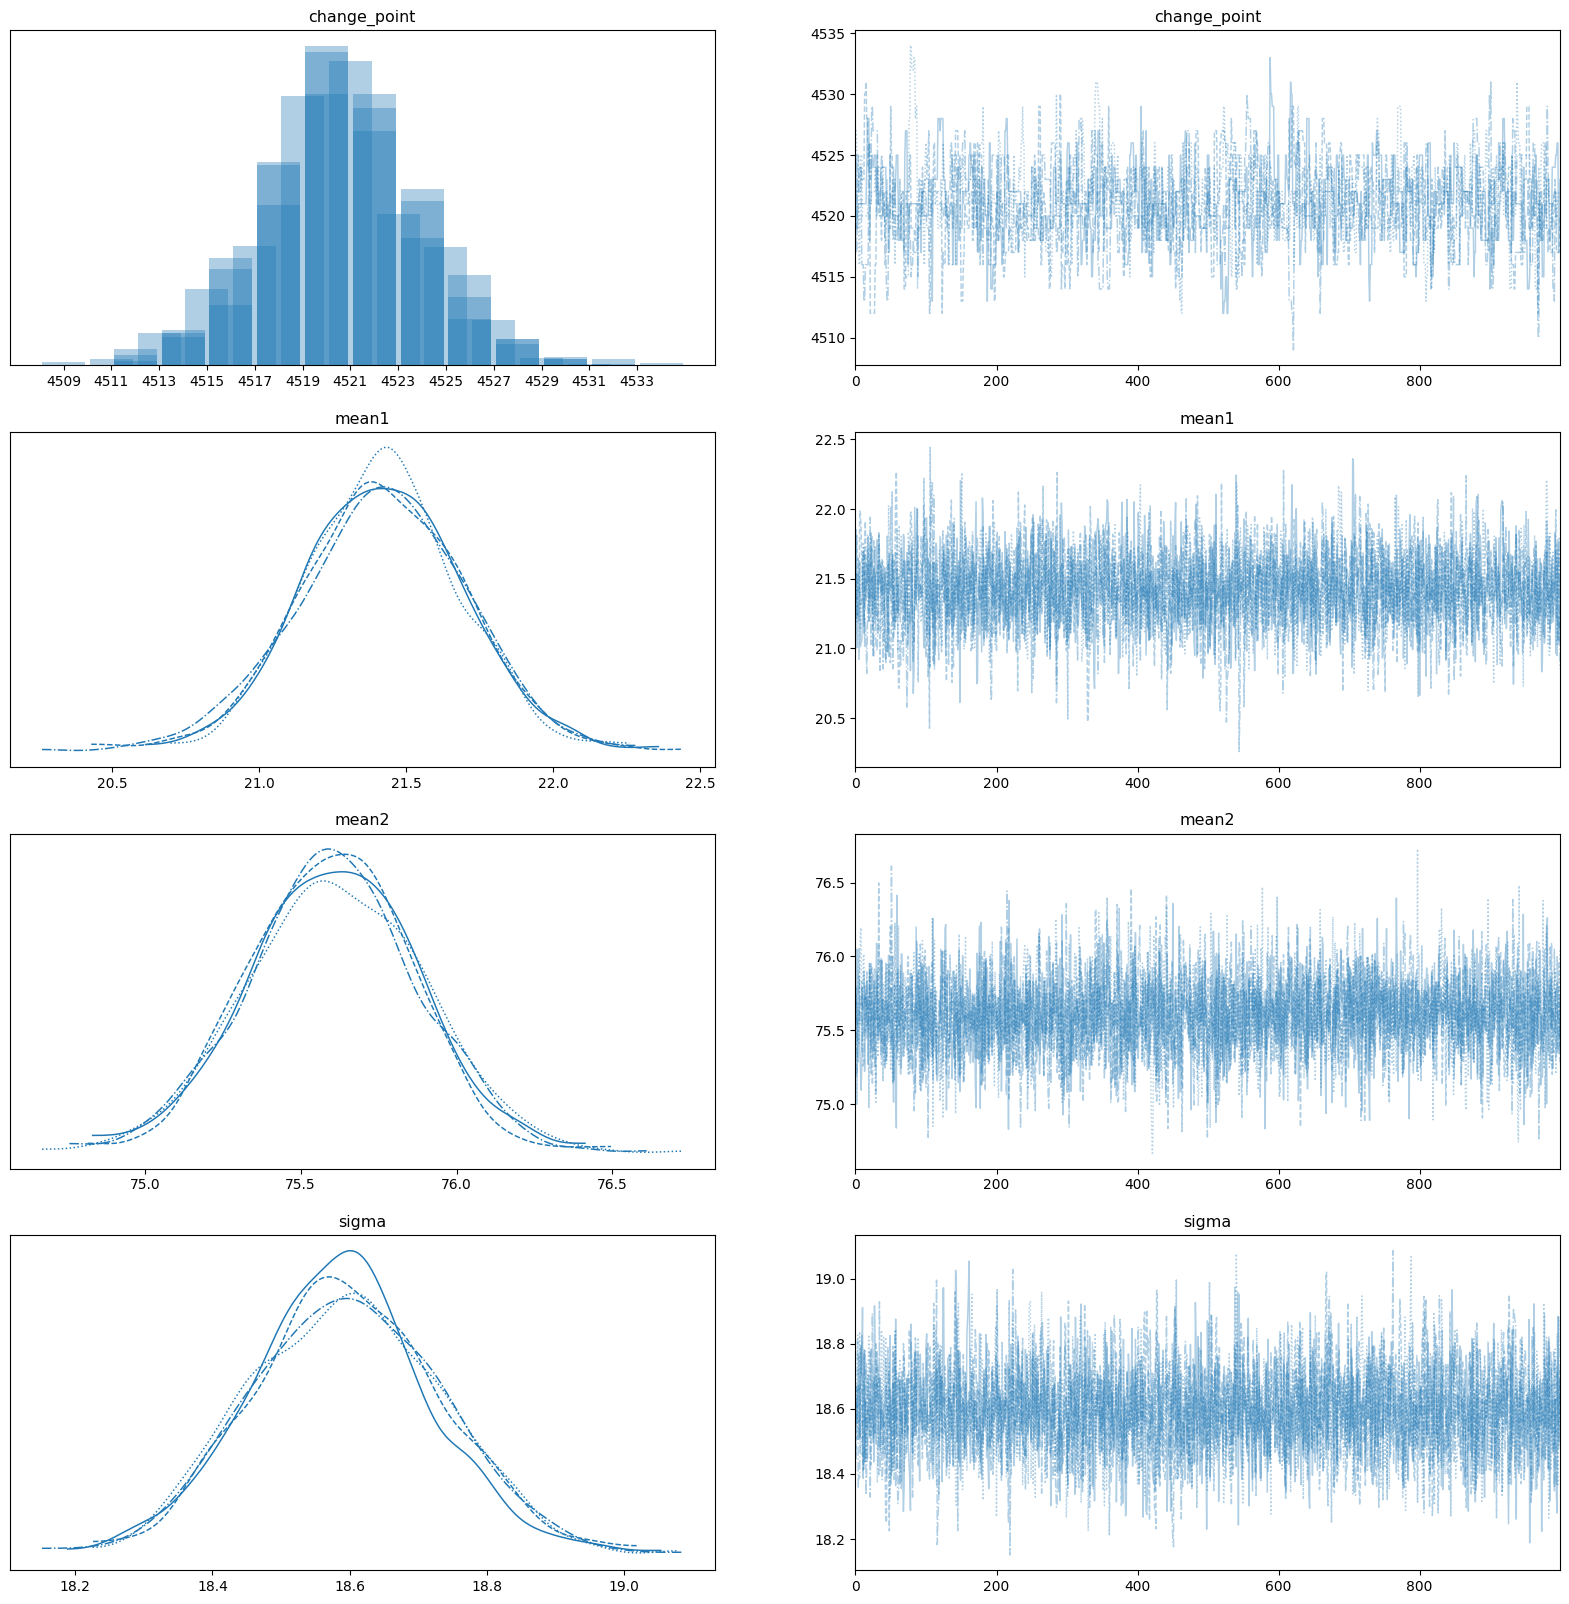

In [23]:
from scripts.changePoint import changePointDetection
changePointDetection(price_data)


### Applying Time Series Analysis to Brent Oil Prices


To detect patterns, trends, and seasonality within Brent oil price data.

#### The parameters 
##### p, d, and 𝑞 in an ARIMA model represent the following:
##### p: The number of autoregressive (AR) terms. This parameter captures how past values affect the current value.
##### d: The order of differencing required to make the time series stationary (removing trends).
##### q: The number of moving average (MA) terms. This parameter accounts for past forecast errors.

### Perform ADF test

In [24]:
from scripts.changePoint import adf_test
adf_test(price_data['Price'])


ADF Statistic: -1.993856
p-value: 0.289274
Fail to reject the null hypothesis (the series is non-stationary)


### ACF and PACF

Autocorrelation (ACF) and Partial Autocorrelation (PACF) Plots:
Use ACF and PACF plots to determine suitable values for 
p and q.
ACF plot: Shows how correlated a time series is with its lagged values. Helps in identifying the MA (q) order.
PACF plot: Shows the partial correlation of a time series with its lagged values. Helps in identifying the AR (p) order.

<Figure size 1200x600 with 0 Axes>

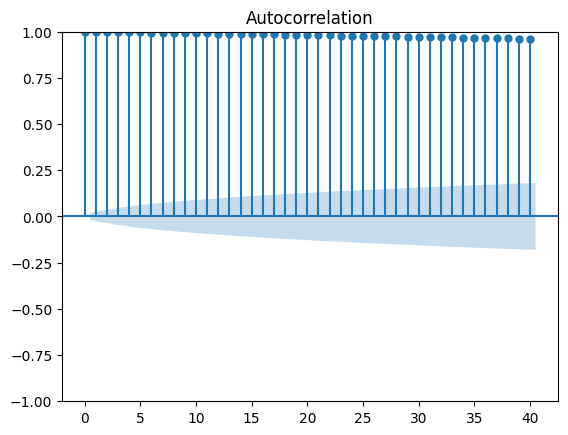

<Figure size 1200x600 with 0 Axes>

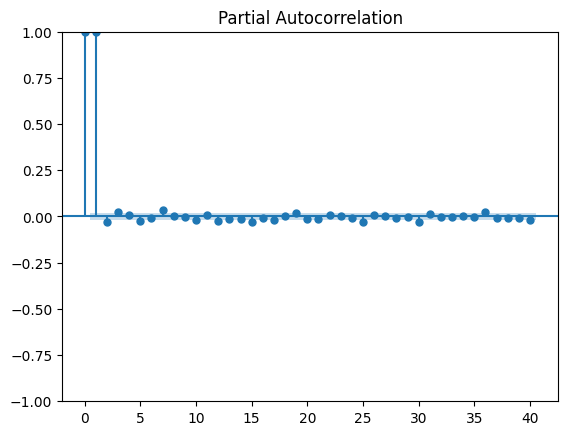

In [25]:
from scripts.changePoint import autoCorrAndPartialAutoCorr
autoCorrAndPartialAutoCorr(price_data)


##### p=1 (based on PACF plot),
##### d=1 (data was non-stationary),
##### q=1 (based on ACF plot),

### ARIMA model


In [26]:
train_size = int(len(price_data) * 0.8)
train, test = price_data[:train_size], price_data[train_size:]


In [27]:
from scripts.changePoint import arimaModel
arima_forecast = arimaModel(price_data,test)


/home/osho/Projects/10AcadameyDADSML/10AcademyWeek10Analysis/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/osho/Projects/10AcadameyDADSML/10AcademyWeek10Analysis/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/osho/Projects/10AcadameyDADSML/10AcademyWeek10Analysis/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9011
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14543.950
Date:                Mon, 04 Nov 2024   AIC                          29093.899
Time:                        15:35:00   BIC                          29115.218
Sample:                             0   HQIC                         29101.153
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3427      0.159     -2.152      0.031      -0.655      -0.031
ma.L1          0.3712      0.157      2.358      0.018       0.063       0.680
sigma2         1.4777      0.008    184.571      0.0

/home/osho/Projects/10AcadameyDADSML/10AcademyWeek10Analysis/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Calculate ARIMA metrics
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
arima_mae = mean_absolute_error(test, arima_forecast)
arima_r2 = r2_score(test, arima_forecast)


In [29]:
print(arima_rmse, arima_mae, arima_r2)


36.99296004571927 33.41574571777544 -2.214186533295874


### Prophet Model


In [30]:
from scripts.changePoint import prophetModel
prophet_forecast, test_prophet = prophetModel(price_data)


Building Prophet model...


15:35:01 - cmdstanpy - INFO - Chain [1] start processing
15:35:08 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
# Calculate Prophet metrics
prophet_rmse = np.sqrt(mean_squared_error(test, prophet_forecast))
prophet_mae = mean_absolute_error(test, prophet_forecast)
prophet_r2 = r2_score(test, prophet_forecast)


In [32]:
print(prophet_rmse,prophet_mae,prophet_r2)


31.864494208302443 28.31155268820136 -1.3847725757885696


### Long Short-Term Memory (LSTM)

Incorporating Machine Learning Models for Deeper Analysis
Objective: Use machine learning models to capture non-linear patterns and dependencies in Brent oil prices.

Methods:

Long Short-Term Memory (LSTM) Networks: Leverage LSTM for time-series forecasting.
Steps:
Data Preparation: Scale the data and structure it for LSTM input.
Model Training: Use a sequential model with LSTM layers.
Evaluation: Use out-of-sample testing and metrics like RMSE

In [33]:
from scripts.changePoint import lstmModel
lstm_rmse, lstm_mae, lstm_r2, lstm_forecast=lstmModel(price_data)


2024-11-04 15:35:11.375878: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 0.0240
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 4.2700e-04
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 3.8526e-04
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 3.7244e-04
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 3.2906e-04
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 3.0180e-04
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 2.5971e-04
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 2.5749e-04
Epoch 9/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 2.4089e-04
Epoch 10/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 2.1234e-04
Epoch 11/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 2.2469e-04
Epoch 12/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 2.0419e-04
Epoch 13/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 1.8472e-04
Epoch 14/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 2

In [35]:
print(lstm_rmse,lstm_mae, lstm_r2)


1.9480399323653121 1.3448366032641683 0.9910808380413638


### Model Evaluation Summary

Comparative Model Evaluation
Insight: By evaluating model performance metrics (RMSE, MAE, and R-squared), you can see which model performs best for specific scenarios:
Low RMSE and MAE: Suggest the model is accurately predicting values close to the actual prices.
High R-squared: Implies the model can explain a significant portion of the variance in the data.

In [36]:
print("\nModel Evaluation Results:")
print("ARIMA - RMSE: {:.2f}, MAE: {:.2f}, R-squared: {:.2f}".format(arima_rmse, arima_mae, arima_r2))
print("Prophet - RMSE: {:.2f}, MAE: {:.2f}, R-squared: {:.2f}".format(prophet_rmse, prophet_mae, prophet_r2))
print("LSTM - RMSE: {:.2f}, MAE: {:.2f}, R-squared: {:.2f}".format(lstm_rmse, lstm_mae, lstm_r2))



Model Evaluation Results:
ARIMA - RMSE: 36.99, MAE: 33.42, R-squared: -2.21
Prophet - RMSE: 31.86, MAE: 28.31, R-squared: -1.38
LSTM - RMSE: 1.95, MAE: 1.34, R-squared: 0.99


###  Plotting the results

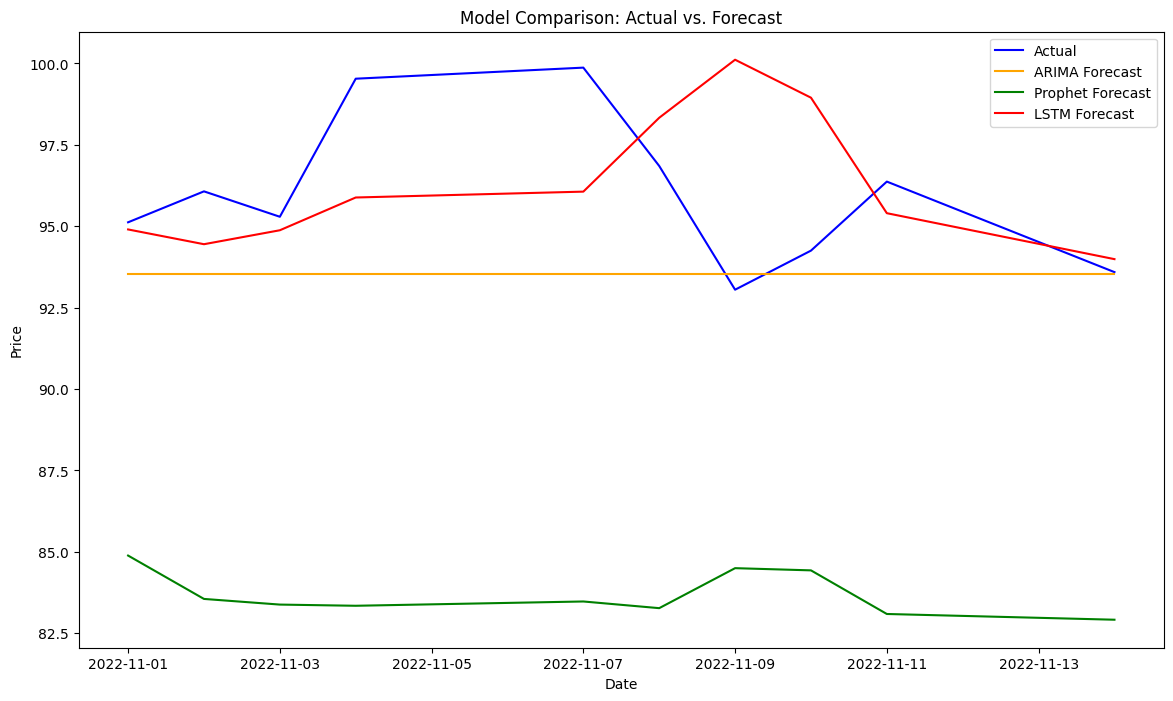

In [37]:
# Align prophet forecast to the length of test_last_period
prophet_forecast = prophet_forecast[-10:]
arima_forecast = arima_forecast[-10:]
lstm_forecast = lstm_forecast[-10:]
test_last_period = test[-10:]

# Plotting
from scripts.changePoint import modelComparison
modelComparison(prophet_forecast,arima_forecast,lstm_forecast,test_last_period)


## Exploring Additional Statistical and Econometric Models

In [38]:

# Set date range and country list
start_date = datetime.datetime(1987, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
countries = ['USA', 'GBR', 'ETH', 'IND', 'CHN', 'DEU']

# Define indicators for GDP, inflation, and unemployment rate
indicators = {
    'NY.GDP.MKTP.CD': 'GDP',                  
    'FP.CPI.TOTL.ZG': 'Inflation',             
    'SL.UEM.TOTL.ZS': 'Unemployment'         
}

# Fetch the data from World Bank
data = wbdata.get_dataframe(indicators, country=countries)
# Reset index and prepare data
data.reset_index(inplace=True)
data['date'] = pd.to_datetime(data['date'])
# Format the values for better readability in output
pd.options.display.float_format = '{:,.2f}'.format
# Filter data to only include dates within the specified range
filtered_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]


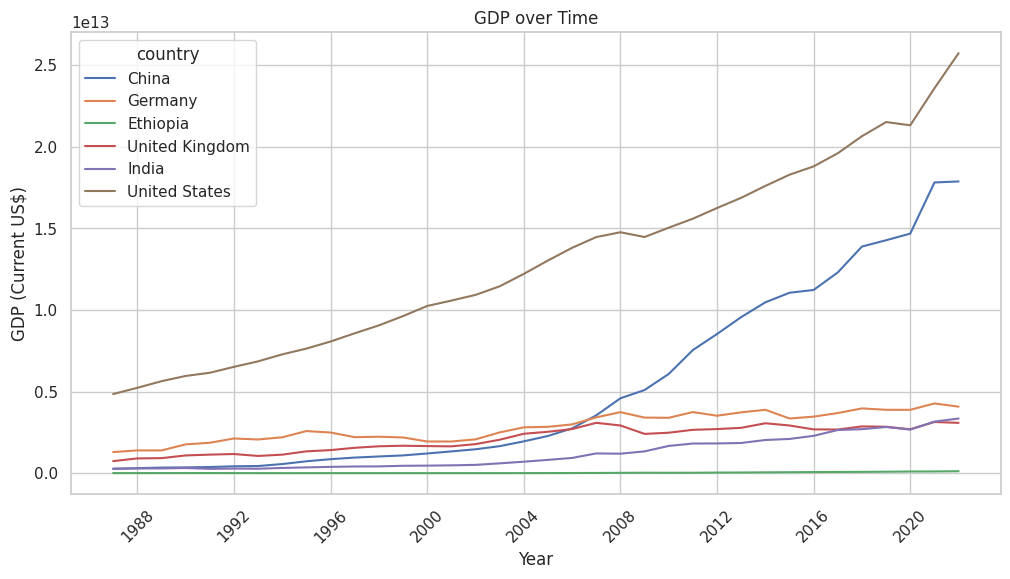

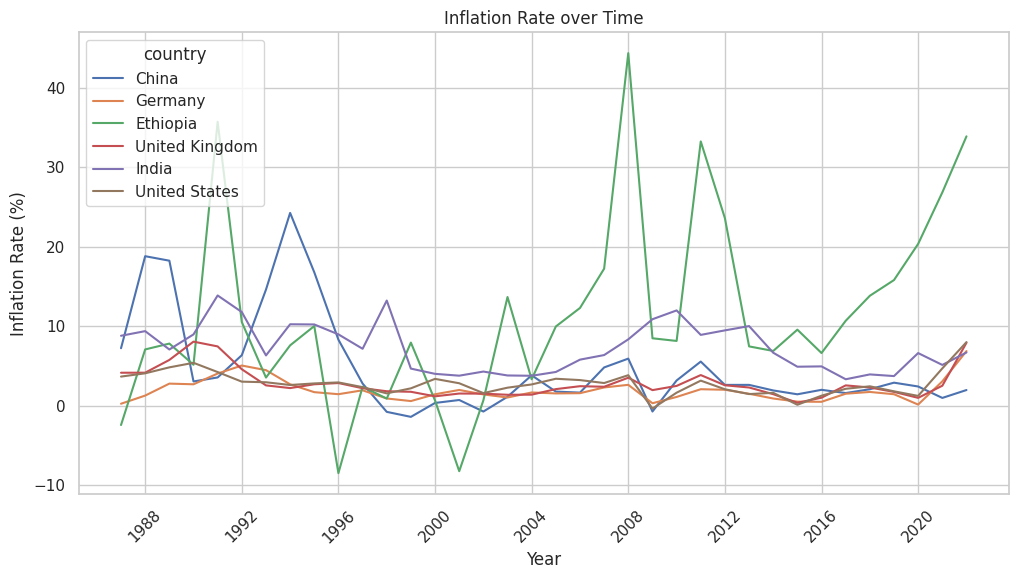

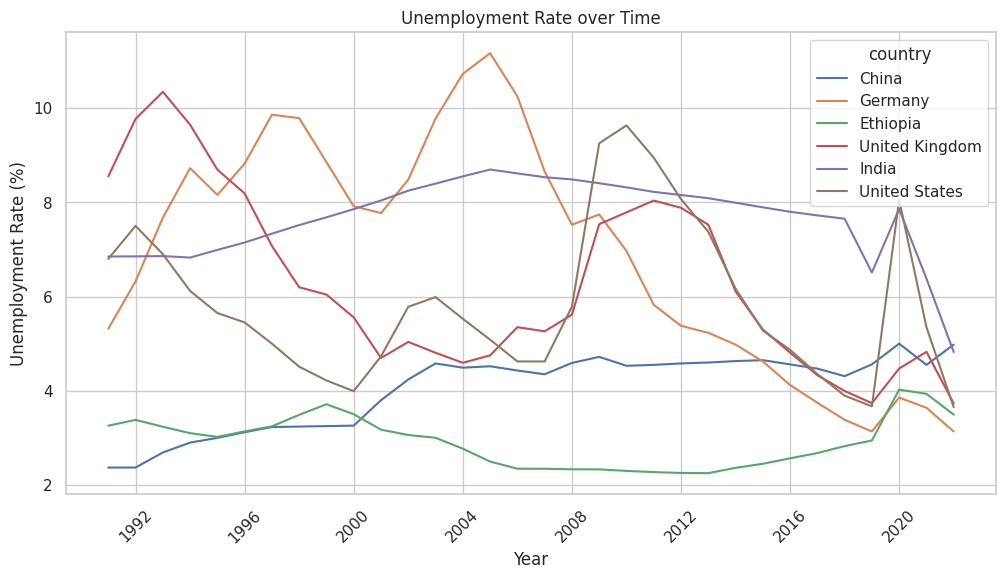

In [39]:
from scripts.changePoint import gdp_Inflation_Unemployee_Country_OverTime
gdp_Inflation_Unemployee_Country_OverTime(filtered_data)


In [40]:
filtered_data.head()
filtered_data.rename(columns={'date': 'Date'}, inplace=True)


In [41]:
merged_price_factors = price_data.merge(filtered_data, on='Date', how='left').fillna(0)


In [42]:
merged_price_factors['Date'] = pd.to_datetime(merged_price_factors['Date'])


In [43]:
merged_price_factors.head()


,Date,Price,country,GDP,Inflation,Unemployment
0,1987-05-20,18.63,0,0.00,0.00,0.00
1,1987-05-21,18.45,0,0.00,0.00,0.00
2,1987-05-22,18.55,0,0.00,0.00,0.00
3,1987-05-25,18.60,0,0.00,0.00,0.00
4,1987-05-26,18.63,0,0.00,0.00,0.00


### Vector Autoregression (VAR) model

In [44]:
from scripts.changePoint import varModel
var_result,var_model =  varModel(merged_price_factors)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 04, Nov, 2024
Time:                     15:37:50
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    43.1869
Nobs:                     9015.00    HQIC:                   43.1765
Log likelihood:          -245741.    FPE:                5.61050e+18
AIC:                      43.1712    Det(Omega_mle):     5.59807e+18
--------------------------------------------------------------------
Results for equation Price
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.038630         0.022813            1.693           0.090
L1.Price                0.999376         0.000390         2563.228           0.000
L1.GDP                 -0.000000         0.000000   

### Summary of a Vector Autoregression (VAR) model

### Impulse Response Function (IRF) 

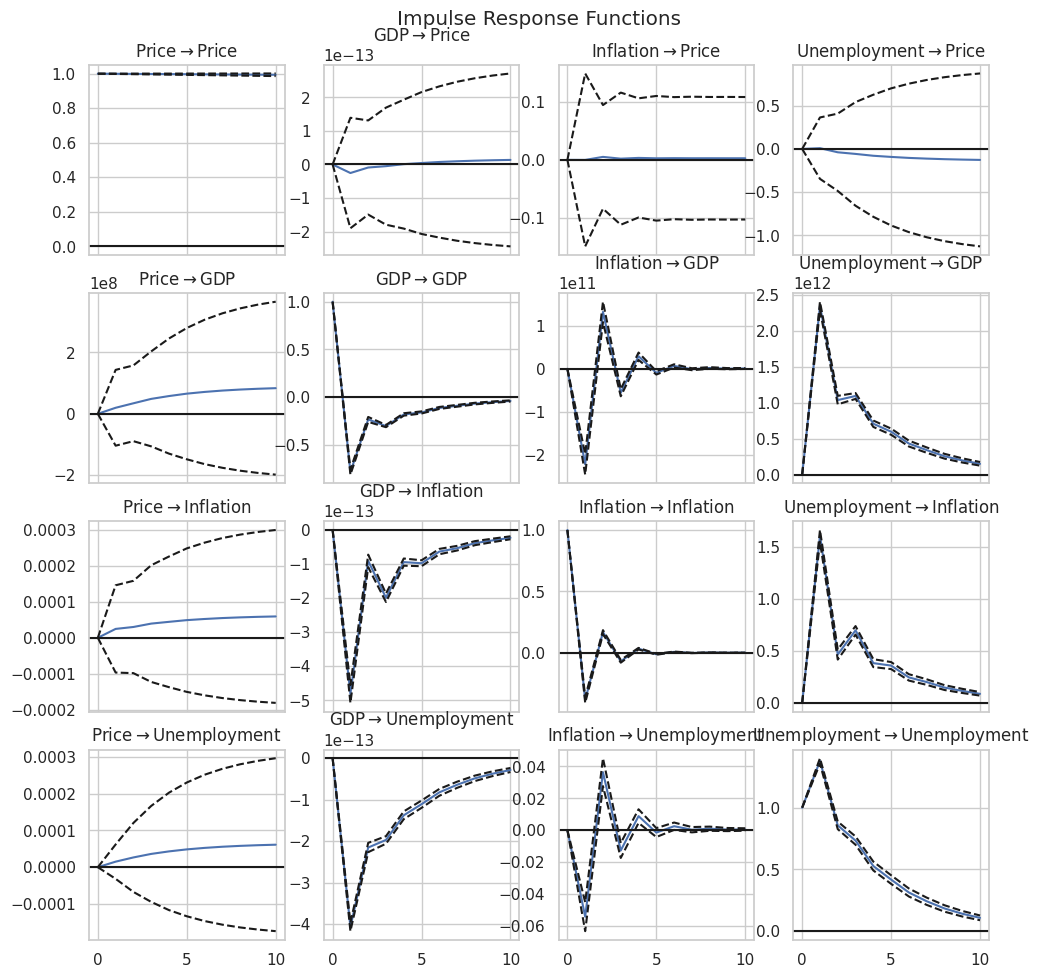

In [45]:
irf = var_result.irf(10) 
irf.plot(orth=False)
plt.suptitle("Impulse Response Functions")
plt.show()


### Forecast Error Variance Decomposition (FEVD)

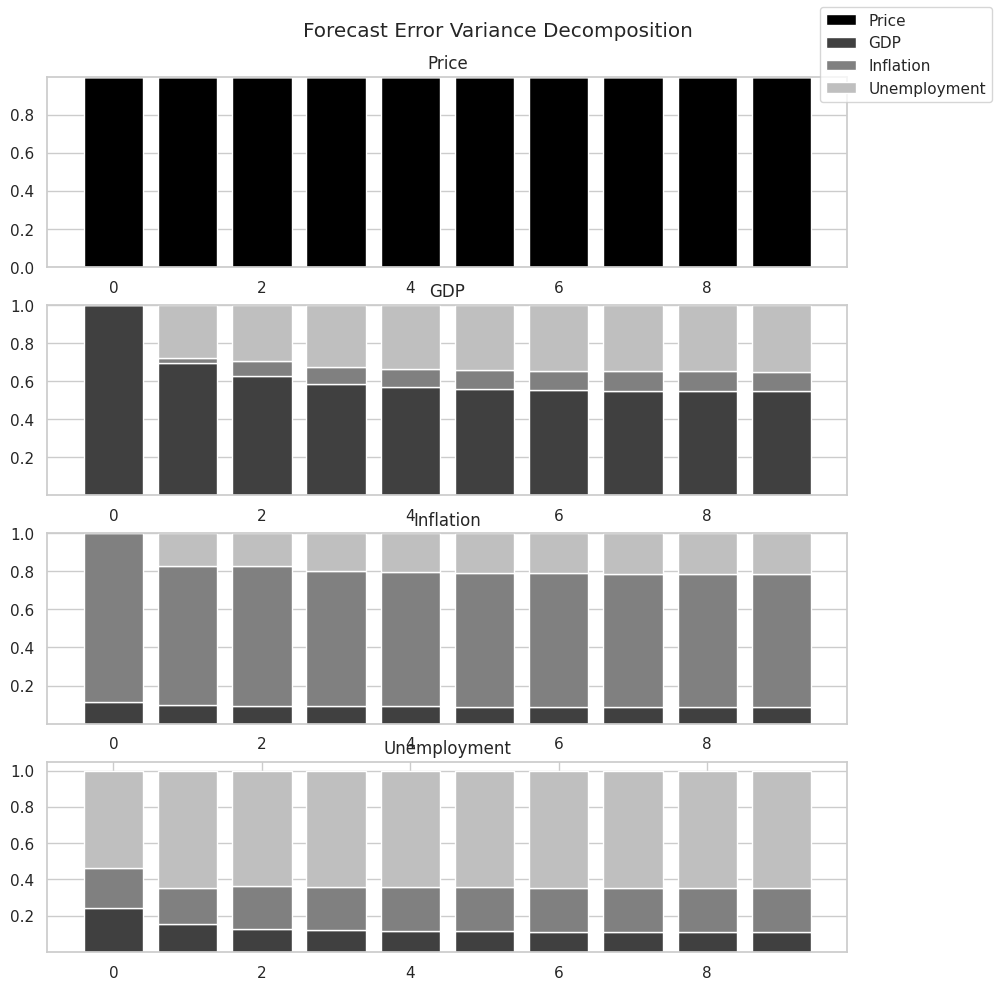

In [46]:
fevd = var_result.fevd(10)
fevd.plot()
plt.suptitle("Forecast Error Variance Decomposition")
plt.show()


### Lag Order Selection Criteria

#### This helps to see how different lag orders compare using criteria like AIC, BIC, HQIC

In [47]:
var_model.select_order(15).summary()


,AIC,BIC,FPE,HQIC
0,51.41,51.42,2.130e+22,51.41
1,43.18,43.19,5.645e+18,43.18
2,27.19,27.22,6.439e+11,27.20
3,9.515,9.556,1.356e+04,9.529
4,12.46,12.51,2.573e+05,12.48
5,6.260,6.326,523.3,6.283
6,5.111*,5.190*,165.9*,5.138*
7,6.597,6.689,733.2,6.629
8,7.174,7.278,1305.,7.209
9,8.449,8.566,4669.,8.488
